In [99]:
import argparse
from datetime import datetime
import os
import pandas as pd

from utils import seed_everything, get_device, check_max_len, clean_gpu
from utils_config import get_model_config
from trainer import Trainer
from utils import prepare_datasets

In [100]:
seed = 1
device = 0
target = 'mirna'
experiment_name = 'jupyter'
verbose=True

In [101]:
kmer=1

In [102]:
max_len = 1024
model_name = 'rnabert'
batch_size=32

d_model = 64
n_layer = 4
rc = False

is_pretrained = True

pooling_mode_target = 'Mean'
is_convblock=False
is_cross_attention=True
rna_model = 'rnabert'

load_pretrain_name='both__rnabert'

In [7]:
trainer = Trainer(
    seed=seed,
    device=device,
    experiment_name=experiment_name,
    verbose=verbose,
)

INFO:utils:Seeds set to 1.
✅ Logging setup complete.


In [53]:
max_len = check_max_len(max_len, model_name)
# df = pd.read_pickle(f'./data/df_final.pkl')
df = pd.read_pickle(f'./data/df_train_final.pkl')
df_test = pd.read_pickle(f'./data/df_test_final.pkl')

INFO:utils:Max length set to 438 for model rnabert


In [54]:
df['length'] = df['circRNA'].apply(len)
df_test['length'] = df_test['circRNA'].apply(len)
# df = df[df['length'] <= max_len]
# df_test = df_test[df_test['length'] <= max_len]

In [55]:
train_dataset, valid_dataset, test_dataset, extra_dataset = prepare_datasets(
        df=df, 
        df_test=df_test,
        max_len=max_len + 2,  # 2 for special tokens (CLS and EOS)
        target=target, 
        seed=seed,
        kmer=kmer,
        # df_extra=df_test,
    )

In [56]:
trainer.set_dataloader(train_dataset, part=0, batch_size=batch_size)
trainer.set_dataloader(valid_dataset, part=1, batch_size=batch_size)
trainer.set_dataloader(test_dataset, part=2, batch_size=batch_size)

In [57]:
# Step 4. Configure Model
print('[Step 4] Configuring Model for training')
config = get_model_config(
    model_name=model_name,
    d_model=d_model,
    n_layer=n_layer,
    verbose=verbose,
    rc=rc,
    vocab_size=train_dataset.vocab_size
)

[Step 4] Configuring Model for training
- Model: rnabert
- d_model: 64
- n_layer: 4


In [58]:
trainer.define_model(
    config=config,
    model_name=model_name,
    pretrain=is_pretrained,
    pooling_mode_target=pooling_mode_target,
    is_convblock=is_convblock,
    is_cross_attention=is_cross_attention,
)

Model 'rnabert' initialized. Pretraining mode: True


In [59]:
trainer.set_pretrained_target(target=target, rna_model=rna_model)

Target model for mirna set with projection dimension 120


Target model for mirna set with projection dimension 120


In [60]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[-0.6936, -0.6486, -0.3635,  ...,  0.7732, -0.8931,  1.6200],
        [ 0.4330, -0.3641,  1.4483,  ..., -0.2284,  2.0395,  0.6826],
        [-0.1248,  0.1369, -0.3198,  ..., -0.1280, -1.1623,  0.1248],
        ...,
        [-0.5975, -0.7201,  0.4118,  ...,  1.6204, -2.6339, -2.0129],
        [-0.4700,  0.4864,  0.0269,  ...,  2.3066,  1.3870, -0.3493],
        [ 2.4004,  0.3097, -0.3960,  ..., -0.4178,  0.0484,  1.2705]],
       device='cuda:0', requires_grad=True)

In [61]:
trainer.load_model(pretrain=False, load_pretrain_name=load_pretrain_name, verbose=True)

X Error while loading the model: Error(s) in loading state_dict for ModelWrapper:
	Missing key(s) in state_dict: "mlm_head.proj.0.weight", "mlm_head.proj.0.bias", "mlm_head.proj.2.weight", "mlm_head.proj.2.bias", "mlm_head.proj.4.weight", "mlm_head.proj.4.bias", "ntp_head.proj.0.weight", "ntp_head.proj.0.bias", "ntp_head.proj.2.weight", "ntp_head.proj.2.bias", "ntp_head.proj.4.weight", "ntp_head.proj.4.bias", "ssp_head.proj.0.weight", "ssp_head.proj.0.bias", "ssp_head.proj.2.weight", "ssp_head.proj.2.bias", "ssp_head.proj.4.weight", "ssp_head.proj.4.bias", "proj_contrastive.weight", "proj_contrastive.bias", "ss_labels_head.enhancer.conv.0.weight", "ss_labels_head.enhancer.conv.0.bias", "ss_labels_head.enhancer.conv.1.weight", "ss_labels_head.enhancer.conv.1.bias", "ss_labels_head.enhancer.conv.1.running_mean", "ss_labels_head.enhancer.conv.1.running_var", "ss_labels_head.enhancer.conv.3.weight", "ss_labels_head.enhancer.conv.3.bias", "ss_labels_head.proj.0.weight", "ss_labels_head.proj

In [62]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[-1.0107,  0.6464, -0.0162,  ..., -0.5414, -0.3706, -0.4518],
        [ 2.2881, -0.2004,  0.8936,  ...,  0.3560,  0.8618, -0.8258],
        [ 1.2268,  1.5160,  0.4271,  ...,  0.0279,  1.3680,  1.1180],
        ...,
        [ 1.0349, -1.4608, -1.5794,  ..., -0.5098,  0.7918, -0.8172],
        [ 1.1368, -1.6148,  1.6895,  ..., -2.3530,  1.5426,  1.4775],
        [ 1.1761, -1.1788, -0.1103,  ...,  0.1881, -0.3385, -0.6711]],
       device='cuda:0', requires_grad=True)

In [63]:
trainer.rc = False
trainer.task = 'both'
trainer.verbose = True

In [64]:
trainer.rc = False

In [65]:
trainer.task = 'both'

In [66]:
results = trainer.inference(data_loader=trainer.test_loader)

In [67]:
results.pop('lengths_sites')
df_results = pd.DataFrame(results)

In [139]:
df_ss = pd.read_pickle('./data/df_circ_ss.pkl')

In [140]:
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import RNA

def extract_positive_spans(binary_array, min_len=1, max_len=None):
    """
    1D binary array에서 연속된 1 구간 추출 (min_len 이상, max_len 이하)
    """
    spans = []
    start = None
    for i, val in enumerate(binary_array):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            span_len = i - start
            if span_len >= min_len and (max_len is None or span_len <= max_len):
                spans.append((start, i))
            start = None
    if start is not None:
        span_len = len(binary_array) - start
        if span_len >= min_len and (max_len is None or span_len <= max_len):
            spans.append((start, len(binary_array)))
    return spans
    
def predict_circRNA_structure_doubled(seq):
    doubled_seq = seq + seq
    fc = RNA.fold_compound(doubled_seq)
    structure, mfe = fc.mfe()
    return structure, mfe, doubled_seq

def get_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0.0


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def get_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0.0


def linear_binding_site_plot_with_overlap(df, sample_idx=0, threshold=0.5, min_span_len=20):
    row = df.iloc[sample_idx]

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    overlap_mask = np.logical_and(pred_mask, true_mask)

    # --- IoU 계산 ---
    iou = get_iou(pred_mask, true_mask)

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.set_xlim(0, len(probs))
    ax.set_ylim(0, 1.0)

    # Overlap zone
    for i in range(len(overlap_mask)):
        if overlap_mask[i]:
            ax.axvspan(i, i+1, color='limegreen', alpha=0.5, label='Overlap' if i == np.where(overlap_mask)[0][0] else "")

    # Predicted spans
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        ax.axvspan(start, end, color='skyblue', alpha=0.4, label="Predicted" if start == extract_positive_spans(preds_binary, min_span_len)[0][0] else "")

    # True spans
    for start, end in extract_positive_spans(sites, min_span_len):
        ax.axvspan(start, end, color='orange', alpha=0.3, label="True" if start == extract_positive_spans(sites, min_span_len)[0][0] else "")

    # --- Line plot 제거됨 ---
    ax.plot(probs, label="Predicted probability", color='black', linewidth=1)

    # plt.title(f"circRNA: {row['isoform_ID']} | miRNA: {row['miRNA_ID']} ")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return iou


def plot_sequence_coloring_from_df(df, sample_idx=0, threshold=0.5, min_span_len=20, row_width=80, fontsize=8, structure = None):
    row = df.iloc[sample_idx]

    # --- sequence ---
    if structure is not None:
        seq = structure
    else:
        seq = row["circRNA"]
    if isinstance(seq, list):
        seq = ''.join(seq)
    sequence = list(seq)

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites), len(sequence))
    probs = probs[:min_len]
    sites = sites[:min_len]
    sequence = sequence[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    # --- 시각화 ---
    length = len(sequence)
    n_rows = (length + row_width - 1) // row_width

    fig, ax = plt.subplots(figsize=(row_width * 0.1, n_rows * 0.5))
    ax.set_xlim(-0.5, row_width + 0.5)
    ax.set_ylim(-n_rows - 0.5, 1 + 0.5)
    ax.axis("off")

    def get_color(i):
        if true_mask[i] and pred_mask[i]:
            return "limegreen"
        elif true_mask[i]:
            return "orange"
        elif pred_mask[i]:
            return "skyblue"
        else:
            return None
            
    for i in range(length):
        row_idx = -(i // row_width)
        col = i % row_width
        base = sequence[i]
        color = get_color(i)
    
        if color:
            rect = patches.Rectangle((col, row_idx), 1, 1, color=color, alpha=0.6)
            ax.add_patch(rect)
    
        ax.text(col + 0.5, row_idx + 0.5, base, ha='center', va='center', 
                fontsize=fontsize, family='monospace', clip_on=False)


    # for i in range(length):
    #     row_idx = -(i // row_width)
    #     col = i % row_width
    #     base = sequence[i]
    #     color = get_color(i)

    #     if color:
    #         rect = patches.Rectangle((col, row_idx), 1, 1, color=color, alpha=0.6)
    #         ax.add_patch(rect)

    #     ax.text(col + 0.5, row_idx + 0.5, base, ha='center', va='center', fontsize=fontsize, family='monospace')

    plt.tight_layout()
    plt.show()


circRNA: GCAGAGAUUGUCAAGAGGCUGAAUGCUAUCUGUGCACAAGUCAUUCCUUUCCUGUCCCAAGAGGGCAUCUCUGAUGUUUUUUAUCUGAACAUCGUCCACCUUGUUUCUUCUUCUGUGCAUUCUGUGAGCAUUGGACUCCUUGCUUCUGCCCUGAAGCCAGAUGGACCAUAAUCUGGAGGGAGGGGAGGAGCAGCACCAGCAACAAGUGGUGCAGGCUGUGGAACGGGCCAAGCAGGUGACCAUGGCAGAACUGAACGCCAUCAUUGGG
structure: ((((.((..(...((.((((...(((.......)))..)))).)).)..))))))(((((((.(((......(((((((.......)))))))(((((...(((((...................))))).)))))....(((((((.((((....((((((........))))))....)))).)))))))((((((........))))))..(((((((.((..((...))..))..)))))))..........))).)).)))))
circRNA ID: chr9|79612656,79615076,79627374|79612718,79615205,79627448|+
miRNA ID: hsa-miR-4691-5p


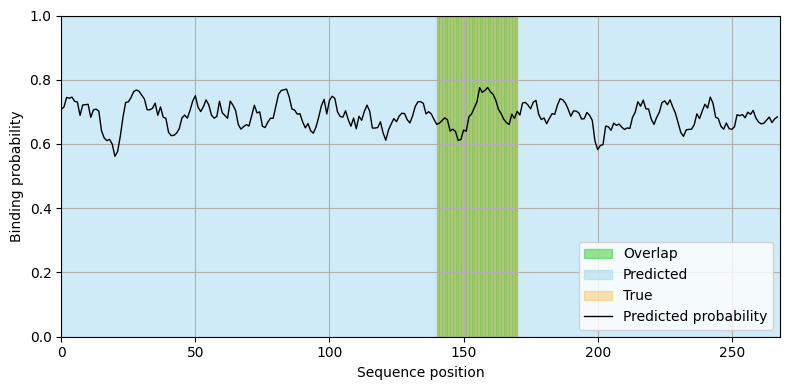

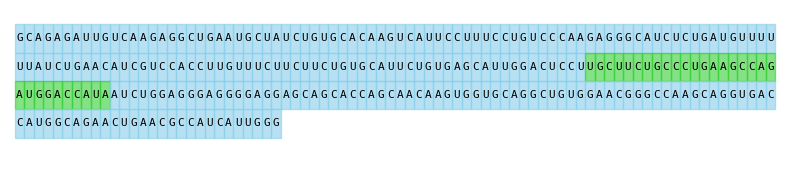

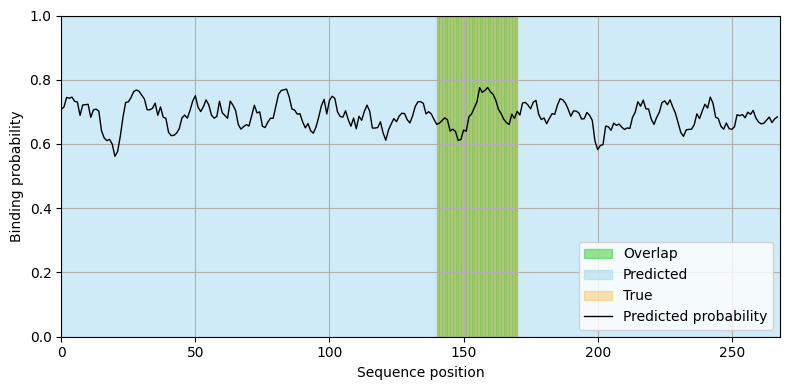

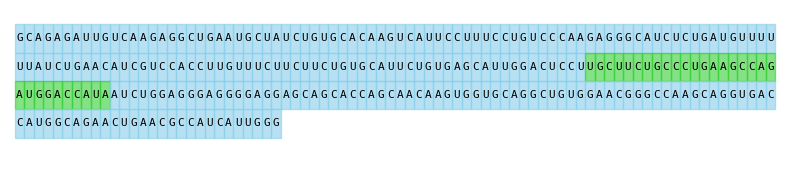

In [141]:
idx = 75638      
# idx = 83393                       
# idx = 62097   
# idx = 27364
# idx = 52018      
# idx = 83393                       
threshold=0.5

circrna_id = df_results['isoform_ID'].iloc[idx]
mirna_seq = df_results['miRNA'].iloc[idx]
mirna_id = df_results['miRNA_ID'].iloc[idx]
circrna_seq = df_results['circRNA'].iloc[idx]
isoform_id = df_results['isoform_ID'].iloc[idx]
try:
    structure = df_ss[df_ss['isoform_ID'] == isoform_id]['structure'].values[0]
except:
    structure = []
if len(structure) < 1:
    print('~~')
    structure, mfe, doubled_seq = predict_circRNA_structure_doubled(circrna_seq)
print(f'circRNA: {circrna_seq}')
print(f'structure: {structure}')
print(f'circRNA ID: {circrna_id}')
print(f'miRNA ID: {mirna_id}')



min_span_len = 1

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
# plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)

min_span_len = len(df_results['miRNA'].iloc[idx])

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
# plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)



circRNA: GCCUCUCUCUGGAACGCCUACCCAACUCCAUCGCCUCCCGCUUCCGCCUGACAGAGAGGGAGGAGGAAGUGAUCACCUGUUUUGAGAGGGCCUCCUGGAUCGCUCAGGUGUUCCUGCAGGAAUUGGAGAAGGGGUGGAGUCUGCCUGGGUCUUGCAGUUGGACAUCCUUCCCUGCUCUCGGUGUCCCAGAAGCUCCUCCCUGGAUCCUGUGAGGAAGCAGGAUCUUGGGACUCCUUCUCCGAGCCUUUCAGAGGCUGGUAAAAGAACCACAAAUAACAGCACGUCGAGGCAUCUGAAAGGCUGUCACCCGCUUGACUAUGAGCUCACCUACUUCCUGGAAGCUGCCCUCCAGAGCGCCUAUGUGAAAAACCUGAAGAAGGG
structure: (((.(((((.((((((......((..(((....((((((.(((..........))).)))))).)))..))......))))))))))))))(.(((((.((((..((((((((.((.(((...((((((((((((((((.((..(((((.(..((((..(((......))))))).......).))))).)))))).(((.(((((((((......))))))))).)))))))))))))))(((((((((((.((((((......)))...................))).)))))))))))((((......))))....((((..((........)).))))..))).))))))))))..))))....))......))))
circRNA ID: chr2|46974973,46975397,46978792|46975103,46975530,46978907|+
miRNA ID: hsa-miR-637


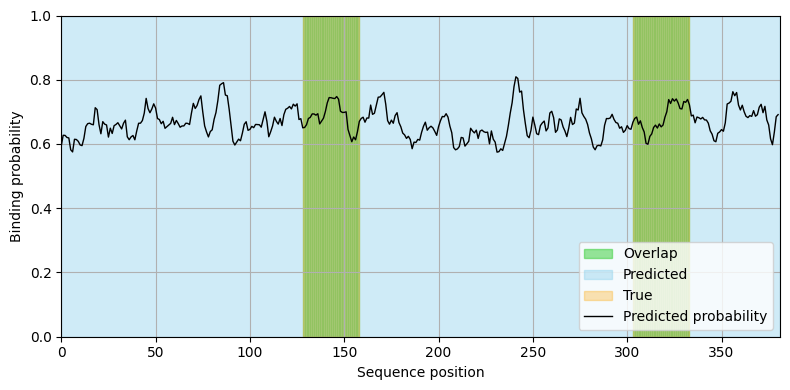

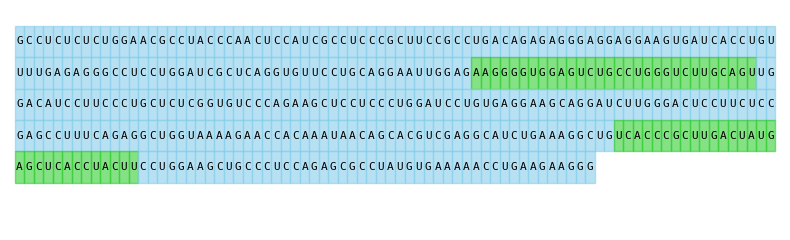

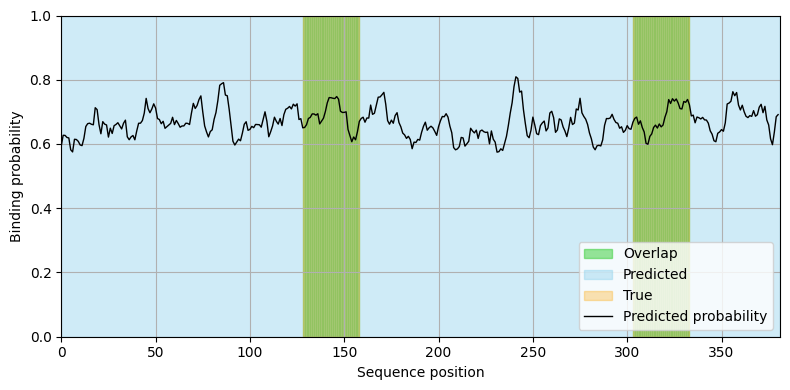

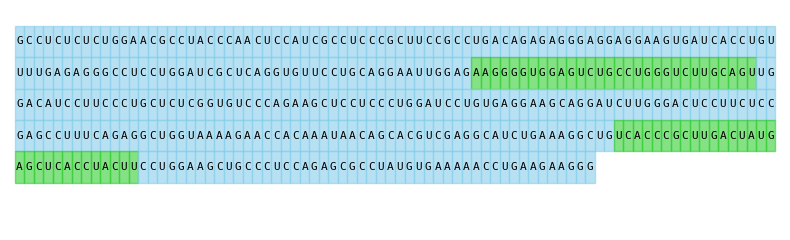

In [142]:
# idx = 75638      
idx = 83393                       



# idx = 62097   
# idx = 27364
# idx = 52018      

threshold=0.5

circrna_id = df_results['isoform_ID'].iloc[idx]
mirna_seq = df_results['miRNA'].iloc[idx]
mirna_id = df_results['miRNA_ID'].iloc[idx]
circrna_seq = df_results['circRNA'].iloc[idx]
isoform_id = df_results['isoform_ID'].iloc[idx]
try:
    structure = df_ss[df_ss['isoform_ID'] == isoform_id]['structure'].values[0]
except:
    structure = []
if len(structure) < 1:
    print('~~')
    structure, mfe, doubled_seq = predict_circRNA_structure_doubled(circrna_seq)
print(f'circRNA: {circrna_seq}')
print(f'structure: {structure}')
print(f'circRNA ID: {circrna_id}')
print(f'miRNA ID: {mirna_id}')



min_span_len = 1

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
# plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)

min_span_len = len(df_results['miRNA'].iloc[idx])

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
# plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)



In [144]:
df_results['isoform_ID'].iloc[idx]

'chr2|46974973,46975397,46978792|46975103,46975530,46978907|+'

In [145]:
df_results['miRNA_ID'].iloc[idx]

'hsa-miR-637'